## long.log - analysis of simulator data 
the dbc simulator is configured to send a log file recorded on 5/12/2018 for one hour for dbc cl66 loco 66054 . 


the loco was involved in lowspeed freight operations and shows several periods of varying groundspeed , engine revs, throttle solenoid operations 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
%matplotlib inline
pd.set_option('display.max_rows', None)


In [2]:
# read in JSON formatted annotated test file
df_log = pd.read_json('long.json', lines=True)
## extract the json from the payload   
df_frames = pd.concat([pd.DataFrame(json_normalize(x,'frames',['vehicleNumber','receiveTimeMs','rmdTimeMs','pktId'], errors='ignore',max_level=0)) for x in df_log['payload']], ignore_index=True )

In [31]:
df_frames['ts'] = pd.to_datetime(df_frames['rmdTimeMs'], unit='ms')
df_frames['ts'] = df_frames['ts'] - df_frames['ts'].iloc[0]

In [32]:
## pivot to create columns for all discrete values
cols = df_frames.pivot( columns='tag', values='value') 

In [33]:
## add cols to main to get the matching timestamps 
full = df_frames.merge(cols, left_index=True, right_index=True)
## index by ts to allow resampling etc .
full.set_index('ts',inplace=True)

In [34]:
throt = full[[
 'SolenoidA',
 'SolenoidB',
 'SolenoidC',
 'SolenoidD','GeneratorField']].fillna(method='ffill')

In [35]:
def calc_pos(row):
   bits=""
   bits += '-' if pd.isna(row['SolenoidA'] )  else '1' if row['SolenoidA']  else '0'
   bits += '-' if row['SolenoidB'] > 0  else '0' if row['SolenoidB'] == 0 else '-'
   bits += '-' if row['SolenoidC'] > 0  else '0' if row['SolenoidC'] == 0 else '-'
   bits += '-' if row['SolenoidD'] > 0  else '0' if row['SolenoidD'] == 0 else '-'
   bits += '-' if row['GeneratorField'] > 0  else '0' if row['GeneratorField'] == 0 else '-'
   
    
   lookup = {
      "00010": -1,
      "00000": 0,
      "00001": 1,
      "10001": 2,
      "00101": 3,
      "10101": 4,
      "01111": 5,
      "11111": 6,
      "01101": 7,
      "11101": 8 }
   if bits in lookup :  
       return lookup[bits]
   else: 
       return None

full['notch'] = throt.apply (lambda row: calc_pos(row), axis=1)

    

# counts of tag values in the long.log file


In [36]:
df_frames.columns

Index(['seq', 'typeCode', 'card', 'channel', 'value', 'ref', 'rawValue', 'tag',
       'dataType', 'vehicleNumber', 'receiveTimeMs', 'rmdTimeMs', 'pktId',
       'ts', 'elapsed'],
      dtype='object')

In [37]:

# show counts of tag vlues in long file
df_frames.groupby('card')['tag'].value_counts()

card  tag                        
2     CoolantTankLevel                 80
      OilQuality                        2
      OilQualitySensorTemp              2
7     GroundSpeedLocomotive          1137
8     SpeedEngine                    1086
      CurrentMainGenerator            819
      VoltageMainGenerator            777
      BrakingAirPressureBogie1        699
      BrakingAirPressureBogie2        683
      PressureBrakePipe               574
      VoltageBattery                    4
      LevelFuelTank                     3
      AmbTemperature                    2
      Booster1                          2
      Booster2                          2
      PressureOilEngine                 2
      TemperatureEngineWater            2
      TemperatureExhaust-1              2
      TemperatureExhaust-2              2
      TemperatureOilEngine              2
9     AutoBrakeOperation              116
      SolenoidA                        72
      GeneratorField                   36


# some example plots of significant data in the test file

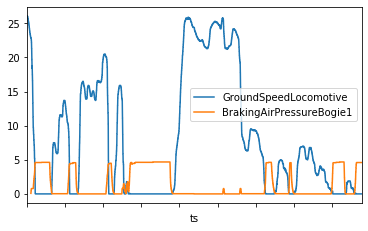

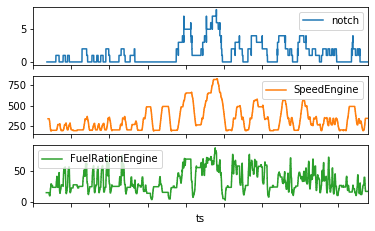

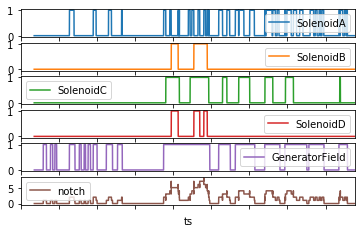

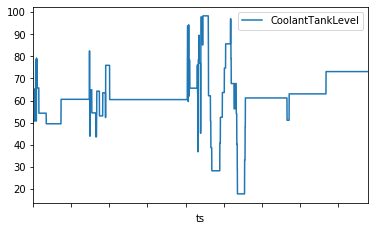

In [38]:
# draw some plots 

ax = plt.gca()
pdata = full.fillna(method='ffill')


# show 2 tags on same axis
pdata.plot( kind="line",y='GroundSpeedLocomotive', ax=ax)
pdata.plot( kind="line",y='BrakingAirPressureBogie1',ax=ax)


# show 3 tags as subplots
pdata.plot( kind="line", y=['notch','SpeedEngine','FuelRationEngine'], subplots=True)


# plot digital signals for throttle pos calcs
pdata.plot( kind="line", y=[
 'SolenoidA',
 'SolenoidB',
 'SolenoidC',
 'SolenoidD','GeneratorField','notch'] , subplots=True)

pdata.plot( kind="line", y='CoolantTankLevel')


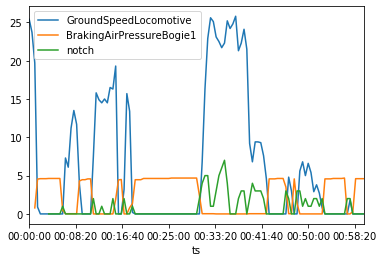

In [39]:

pdata = full.resample('30S').last().fillna(method='ffill')
# show 2 tags on same axis
ax = plt.gca()

pdata.plot( kind="line",y='GroundSpeedLocomotive', ax=ax)
pdata.plot( kind="line",y='BrakingAirPressureBogie1',ax=ax)
pdata.plot( kind="line",y='notch',ax=ax)

In [40]:
# summarise some specific tags
full[['GroundSpeedLocomotive','SpeedEngine','CoolantTankLevel','notch']].describe()

,GroundSpeedLocomotive,SpeedEngine,CoolantTankLevel,notch
count,1137.000000,1086.000000,80.000000,21053.000000
mean,11.986544,352.464345,63.758257,1.328979
std,8.202512,127.818063,16.918246,1.659236
min,0.000000,188.235200,17.736775,0.000000
25%,4.800000,258.823400,52.631372,0.000000
50%,10.900000,319.999840,63.216683,1.000000
75%,20.100000,423.529200,78.294595,2.000000
max,26.100000,828.234880,98.357450,8.000000


In [41]:
pdata[['GroundSpeedLocomotive','SpeedEngine','CoolantTankLevel']].describe()

,GroundSpeedLocomotive,SpeedEngine,CoolantTankLevel
count,121.000000,114.000000,121.000000
mean,6.373554,300.392007,61.497053
std,8.703666,141.965334,10.392499
min,0.000000,192.941080,17.736775
25%,0.000000,198.823430,60.447270
50%,0.000000,202.352840,60.570355
75%,11.700000,348.235120,63.032055
max,25.800000,818.823120,98.357450


In [42]:
full.to_csv('long.csv')

In [43]:
pdata.to_csv('30-summary.csv')